In [1]:
import torch
import pandas as pd
import numpy as np
import os
import sys
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
sys.path.append('../')
from util.base_dataset import FaceEdgeFolder
from baselines.models.C3D.C3D_model import C3DVidPredNet, C3D_discNet
import baselines.models.C3D.networks as network

In [4]:
Epoch = 2000
BatchSize = 4
ImgSize = (128, 128)
Shuffle = True
NumWorkers = 1
UseLsgan = True

In [5]:
df = pd.read_csv('../dataset/emotion_id_clean.csv')

train_dataset = FaceEdgeFolder('../dataset/face_landmark/front_data/preprocess_edgeImgs/', df, samp_len=7,
                        transform=transforms.Compose((transforms.Resize(ImgSize),
                                                     transforms.ToTensor())),
                              samp_interv = [2, 4, 8, 10])
dataloader = DataLoader(train_dataset, batch_size=BatchSize,
                       shuffle=Shuffle, num_workers=NumWorkers)

/home/yaosy/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tensor_type = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
model = C3DVidPredNet(use_dropout=True, use_lsgan=UseLsgan)
disc_model = C3D_discNet(use_lsgan=UseLsgan).to(device)
model.to(device)

if UseLsgan:
    dist_loss = nn.L1Loss()
else:
    dist_lost = nn.BCELoss()
GAN_loss = network.GANLoss(UseLsgan, tensor=tensor_type)
optimizer_G = torch.optim.Adam(model.parameters())
optimizer_D = torch.optim.Adam(disc_model.parameters())

In [7]:
disc_model

C3D_discNet(
  (conv1): Conv3d(1, 64, kernel_size=(1, 4, 4), stride=(2, 2, 2), padding=(0, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(1, 4, 4), stride=(2, 2, 2), padding=(0, 1, 1), bias=False)
  (conv3): Conv3d(128, 256, kernel_size=(1, 4, 4), stride=(2, 2, 2), padding=(0, 1, 1), bias=False)
  (conv4): Conv3d(256, 512, kernel_size=(1, 4, 4), stride=(2, 2, 2), padding=(0, 1, 1), bias=False)
  (conv5a): Conv3d(512, 512, kernel_size=(1, 4, 4), stride=(2, 2, 2), padding=(0, 1, 1), bias=False)
  (downnorm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downnorm3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downnorm4): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downnorm5): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downnorm5_1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downrelu): LeakyR

In [10]:
model.train()

optimizer_G = torch.optim.Adam(model.parameters(), 1e-4)
optimizer_D = torch.optim.Adam(disc_model.parameters(), 1e-4)
with torch.set_grad_enabled(True):
    for epoch in range(Epoch):
        print("Epoch {}/{}".format(epoch+1, Epoch))
        print('-' * 10)
        
        running_loss = 0.0
        for i, samp in enumerate(dataloader):
            train_tensor = samp['first_img'].to(device)
            true_tensor = samp['succeed_imgs'].to(device)
            emotion_tensor = samp['emotion_label'].to(device)
            # print(emotion_tensor.shape)

            # model.zero_grad()
            pred_tensor = model(train_tensor, emotion_tensor)
            
            fake_pairs = torch.cat((train_tensor, pred_tensor.detach()), dim=2)
            pred_fake_pool = disc_model(fake_pairs)
            loss_D_fake = GAN_loss(pred_fake_pool, False)
            
            true_pairs = torch.cat((train_tensor, true_tensor), dim=2)
            pred_true = disc_model(true_pairs)
            loss_D_real = GAN_loss(pred_true, True)
            
            fake_true_pairs = torch.cat((train_tensor, pred_tensor), dim=2)
            pred_fake = disc_model(fake_true_pairs)
            loss_G_C3D = GAN_loss(pred_fake, True)
            
            loss_dist = dist_loss(pred_tensor, true_tensor) * 4
            
            loss_D = (loss_D_fake + loss_D_real) * 0.5
            loss_G = loss_G_C3D + loss_dist

            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()
            
            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()
            
            if i % 2 == 0:
                print('loss D_real: {:.3f}, loss D_fake: {:.3f}, loss G: {:.3f}, dist loss: {:.3f}' \
                      .format(loss_D_real, loss_D_fake, loss_G_C3D, loss_dist))
            

Epoch 1/2000
----------
loss D_real: 0.445, loss D_fake: 0.179, loss G: 0.447, dist loss: 0.057
loss D_real: 0.394, loss D_fake: 0.162, loss G: 0.394, dist loss: 0.068
loss D_real: 0.367, loss D_fake: 0.160, loss G: 0.365, dist loss: 0.047
loss D_real: 0.396, loss D_fake: 0.155, loss G: 0.393, dist loss: 0.072
loss D_real: 0.348, loss D_fake: 0.172, loss G: 0.347, dist loss: 0.061
loss D_real: 0.468, loss D_fake: 0.166, loss G: 0.482, dist loss: 0.065
loss D_real: 0.404, loss D_fake: 0.179, loss G: 0.402, dist loss: 0.064
loss D_real: 0.444, loss D_fake: 0.174, loss G: 0.446, dist loss: 0.074
loss D_real: 0.361, loss D_fake: 0.161, loss G: 0.363, dist loss: 0.070
loss D_real: 0.421, loss D_fake: 0.170, loss G: 0.421, dist loss: 0.057
loss D_real: 0.409, loss D_fake: 0.199, loss G: 0.411, dist loss: 0.051
loss D_real: 0.370, loss D_fake: 0.174, loss G: 0.366, dist loss: 0.062
loss D_real: 0.406, loss D_fake: 0.187, loss G: 0.409, dist loss: 0.064
loss D_real: 0.420, loss D_fake: 0.159, 

loss D_real: 0.410, loss D_fake: 0.142, loss G: 0.449, dist loss: 0.060
loss D_real: 0.330, loss D_fake: 0.182, loss G: 0.331, dist loss: 0.064
loss D_real: 0.342, loss D_fake: 0.174, loss G: 0.343, dist loss: 0.060
loss D_real: 0.423, loss D_fake: 0.191, loss G: 0.426, dist loss: 0.061
loss D_real: 0.435, loss D_fake: 0.191, loss G: 0.434, dist loss: 0.059
loss D_real: 0.363, loss D_fake: 0.179, loss G: 0.364, dist loss: 0.069
loss D_real: 0.380, loss D_fake: 0.164, loss G: 0.383, dist loss: 0.069
loss D_real: 0.379, loss D_fake: 0.184, loss G: 0.381, dist loss: 0.066
loss D_real: 0.407, loss D_fake: 0.181, loss G: 0.409, dist loss: 0.058
loss D_real: 0.328, loss D_fake: 0.188, loss G: 0.329, dist loss: 0.047
loss D_real: 0.352, loss D_fake: 0.186, loss G: 0.357, dist loss: 0.055
loss D_real: 0.324, loss D_fake: 0.192, loss G: 0.325, dist loss: 0.063
loss D_real: 0.444, loss D_fake: 0.185, loss G: 0.445, dist loss: 0.074
loss D_real: 0.404, loss D_fake: 0.201, loss G: 0.407, dist loss

loss D_real: 0.304, loss D_fake: 0.203, loss G: 0.305, dist loss: 0.061
loss D_real: 0.314, loss D_fake: 0.196, loss G: 0.313, dist loss: 0.059
loss D_real: 0.336, loss D_fake: 0.196, loss G: 0.342, dist loss: 0.060
loss D_real: 0.441, loss D_fake: 0.188, loss G: 0.441, dist loss: 0.060
loss D_real: 0.309, loss D_fake: 0.199, loss G: 0.309, dist loss: 0.059
loss D_real: 0.372, loss D_fake: 0.193, loss G: 0.372, dist loss: 0.065
loss D_real: 0.356, loss D_fake: 0.185, loss G: 0.354, dist loss: 0.056
loss D_real: 0.401, loss D_fake: 0.195, loss G: 0.402, dist loss: 0.059
loss D_real: 0.409, loss D_fake: 0.182, loss G: 0.408, dist loss: 0.059
loss D_real: 0.373, loss D_fake: 0.218, loss G: 0.371, dist loss: 0.066
loss D_real: 0.446, loss D_fake: 0.181, loss G: 0.450, dist loss: 0.063
loss D_real: 0.308, loss D_fake: 0.199, loss G: 0.308, dist loss: 0.055
loss D_real: 0.358, loss D_fake: 0.180, loss G: 0.348, dist loss: 0.054
loss D_real: 0.337, loss D_fake: 0.179, loss G: 0.338, dist loss

loss D_real: 0.316, loss D_fake: 0.208, loss G: 0.316, dist loss: 0.056
loss D_real: 0.379, loss D_fake: 0.206, loss G: 0.387, dist loss: 0.064
loss D_real: 0.328, loss D_fake: 0.194, loss G: 0.319, dist loss: 0.067
loss D_real: 0.291, loss D_fake: 0.214, loss G: 0.292, dist loss: 0.059
loss D_real: 0.311, loss D_fake: 0.201, loss G: 0.309, dist loss: 0.066
loss D_real: 0.353, loss D_fake: 0.190, loss G: 0.348, dist loss: 0.067
loss D_real: 0.322, loss D_fake: 0.199, loss G: 0.314, dist loss: 0.042
loss D_real: 0.262, loss D_fake: 0.287, loss G: 0.275, dist loss: 0.064
loss D_real: 0.332, loss D_fake: 0.210, loss G: 0.332, dist loss: 0.056
loss D_real: 0.313, loss D_fake: 0.205, loss G: 0.315, dist loss: 0.063
loss D_real: 0.293, loss D_fake: 0.209, loss G: 0.296, dist loss: 0.062
loss D_real: 0.389, loss D_fake: 0.193, loss G: 0.390, dist loss: 0.060
Epoch 14/2000
----------
loss D_real: 0.412, loss D_fake: 0.190, loss G: 0.415, dist loss: 0.056
loss D_real: 0.293, loss D_fake: 0.211,

loss D_real: 0.301, loss D_fake: 0.206, loss G: 0.302, dist loss: 0.063
loss D_real: 0.370, loss D_fake: 0.202, loss G: 0.368, dist loss: 0.070
loss D_real: 0.377, loss D_fake: 0.193, loss G: 0.375, dist loss: 0.057
loss D_real: 0.281, loss D_fake: 0.222, loss G: 0.281, dist loss: 0.067
loss D_real: 0.381, loss D_fake: 0.209, loss G: 0.380, dist loss: 0.071
loss D_real: 0.350, loss D_fake: 0.204, loss G: 0.351, dist loss: 0.064
loss D_real: 0.323, loss D_fake: 0.199, loss G: 0.326, dist loss: 0.059
Epoch 18/2000
----------
loss D_real: 0.307, loss D_fake: 0.203, loss G: 0.311, dist loss: 0.061
loss D_real: 0.294, loss D_fake: 0.211, loss G: 0.294, dist loss: 0.059
loss D_real: 0.318, loss D_fake: 0.201, loss G: 0.314, dist loss: 0.056
loss D_real: 0.364, loss D_fake: 0.219, loss G: 0.368, dist loss: 0.073
loss D_real: 0.300, loss D_fake: 0.200, loss G: 0.312, dist loss: 0.061
loss D_real: 0.298, loss D_fake: 0.211, loss G: 0.294, dist loss: 0.059
loss D_real: 0.344, loss D_fake: 0.208,

loss D_real: 0.345, loss D_fake: 0.210, loss G: 0.347, dist loss: 0.067
loss D_real: 0.388, loss D_fake: 0.211, loss G: 0.390, dist loss: 0.067
Epoch 22/2000
----------
loss D_real: 0.268, loss D_fake: 0.234, loss G: 0.270, dist loss: 0.060
loss D_real: 0.408, loss D_fake: 0.188, loss G: 0.405, dist loss: 0.058
loss D_real: 0.310, loss D_fake: 0.209, loss G: 0.299, dist loss: 0.062
loss D_real: 0.285, loss D_fake: 0.217, loss G: 0.288, dist loss: 0.058
loss D_real: 0.326, loss D_fake: 0.217, loss G: 0.333, dist loss: 0.062
loss D_real: 0.284, loss D_fake: 0.220, loss G: 0.284, dist loss: 0.064
loss D_real: 0.288, loss D_fake: 0.220, loss G: 0.287, dist loss: 0.060
loss D_real: 0.317, loss D_fake: 0.209, loss G: 0.314, dist loss: 0.068
loss D_real: 0.270, loss D_fake: 0.243, loss G: 0.267, dist loss: 0.068
loss D_real: 0.392, loss D_fake: 0.213, loss G: 0.392, dist loss: 0.063
loss D_real: 0.285, loss D_fake: 0.226, loss G: 0.287, dist loss: 0.057
loss D_real: 0.330, loss D_fake: 0.227,

loss D_real: 0.261, loss D_fake: 0.248, loss G: 0.260, dist loss: 0.060
loss D_real: 0.284, loss D_fake: 0.217, loss G: 0.286, dist loss: 0.053
loss D_real: 0.334, loss D_fake: 0.217, loss G: 0.335, dist loss: 0.064
loss D_real: 0.297, loss D_fake: 0.212, loss G: 0.294, dist loss: 0.056
loss D_real: 0.313, loss D_fake: 0.217, loss G: 0.316, dist loss: 0.062
loss D_real: 0.286, loss D_fake: 0.217, loss G: 0.286, dist loss: 0.059
loss D_real: 0.379, loss D_fake: 0.211, loss G: 0.388, dist loss: 0.062
loss D_real: 0.288, loss D_fake: 0.216, loss G: 0.287, dist loss: 0.072
loss D_real: 0.289, loss D_fake: 0.215, loss G: 0.288, dist loss: 0.061
loss D_real: 0.266, loss D_fake: 0.237, loss G: 0.269, dist loss: 0.064
loss D_real: 0.302, loss D_fake: 0.216, loss G: 0.302, dist loss: 0.061
loss D_real: 0.369, loss D_fake: 0.221, loss G: 0.372, dist loss: 0.058
loss D_real: 0.358, loss D_fake: 0.215, loss G: 0.372, dist loss: 0.072
loss D_real: 0.328, loss D_fake: 0.248, loss G: 0.362, dist loss

loss D_real: 0.311, loss D_fake: 0.213, loss G: 0.313, dist loss: 0.064
loss D_real: 0.433, loss D_fake: 0.197, loss G: 0.434, dist loss: 0.064
loss D_real: 0.301, loss D_fake: 0.224, loss G: 0.290, dist loss: 0.068
loss D_real: 0.336, loss D_fake: 0.222, loss G: 0.337, dist loss: 0.059
loss D_real: 0.270, loss D_fake: 0.230, loss G: 0.271, dist loss: 0.075
loss D_real: 0.262, loss D_fake: 0.238, loss G: 0.266, dist loss: 0.061
loss D_real: 0.353, loss D_fake: 0.230, loss G: 0.358, dist loss: 0.065
loss D_real: 0.270, loss D_fake: 0.232, loss G: 0.270, dist loss: 0.060
loss D_real: 0.268, loss D_fake: 0.235, loss G: 0.268, dist loss: 0.049
loss D_real: 0.321, loss D_fake: 0.214, loss G: 0.317, dist loss: 0.058
loss D_real: 0.318, loss D_fake: 0.217, loss G: 0.323, dist loss: 0.063
loss D_real: 0.316, loss D_fake: 0.226, loss G: 0.316, dist loss: 0.063
loss D_real: 0.269, loss D_fake: 0.237, loss G: 0.266, dist loss: 0.058
loss D_real: 0.380, loss D_fake: 0.213, loss G: 0.384, dist loss

loss D_real: 0.393, loss D_fake: 0.211, loss G: 0.382, dist loss: 0.057
loss D_real: 0.279, loss D_fake: 0.236, loss G: 0.304, dist loss: 0.046
loss D_real: 0.315, loss D_fake: 0.227, loss G: 0.315, dist loss: 0.070
loss D_real: 0.277, loss D_fake: 0.230, loss G: 0.273, dist loss: 0.066
loss D_real: 0.315, loss D_fake: 0.234, loss G: 0.315, dist loss: 0.058
loss D_real: 0.354, loss D_fake: 0.204, loss G: 0.363, dist loss: 0.059
loss D_real: 0.330, loss D_fake: 0.232, loss G: 0.332, dist loss: 0.061
loss D_real: 0.297, loss D_fake: 0.232, loss G: 0.297, dist loss: 0.063
loss D_real: 0.337, loss D_fake: 0.226, loss G: 0.343, dist loss: 0.057
loss D_real: 0.261, loss D_fake: 0.238, loss G: 0.263, dist loss: 0.063
loss D_real: 0.271, loss D_fake: 0.233, loss G: 0.271, dist loss: 0.073
loss D_real: 0.302, loss D_fake: 0.221, loss G: 0.286, dist loss: 0.058
loss D_real: 0.333, loss D_fake: 0.213, loss G: 0.334, dist loss: 0.069
loss D_real: 0.300, loss D_fake: 0.218, loss G: 0.291, dist loss

loss D_real: 0.279, loss D_fake: 0.228, loss G: 0.290, dist loss: 0.060
loss D_real: 0.312, loss D_fake: 0.220, loss G: 0.308, dist loss: 0.076
loss D_real: 0.328, loss D_fake: 0.224, loss G: 0.342, dist loss: 0.063
loss D_real: 0.253, loss D_fake: 0.249, loss G: 0.256, dist loss: 0.065
loss D_real: 0.276, loss D_fake: 0.230, loss G: 0.300, dist loss: 0.073
loss D_real: 0.400, loss D_fake: 0.212, loss G: 0.382, dist loss: 0.063
loss D_real: 0.245, loss D_fake: 0.252, loss G: 0.268, dist loss: 0.069
loss D_real: 0.391, loss D_fake: 0.194, loss G: 0.387, dist loss: 0.061
loss D_real: 0.362, loss D_fake: 0.197, loss G: 0.366, dist loss: 0.060
Epoch 39/2000
----------
loss D_real: 0.379, loss D_fake: 0.214, loss G: 0.360, dist loss: 0.060
loss D_real: 0.269, loss D_fake: 0.237, loss G: 0.283, dist loss: 0.061
loss D_real: 0.360, loss D_fake: 0.168, loss G: 0.411, dist loss: 0.058
loss D_real: 0.334, loss D_fake: 0.217, loss G: 0.332, dist loss: 0.060
loss D_real: 0.325, loss D_fake: 0.209,

loss D_real: 0.336, loss D_fake: 0.241, loss G: 0.340, dist loss: 0.060
loss D_real: 0.329, loss D_fake: 0.217, loss G: 0.340, dist loss: 0.059
loss D_real: 0.248, loss D_fake: 0.253, loss G: 0.249, dist loss: 0.064
loss D_real: 0.353, loss D_fake: 0.207, loss G: 0.354, dist loss: 0.061
Epoch 43/2000
----------
loss D_real: 0.243, loss D_fake: 0.258, loss G: 0.244, dist loss: 0.055
loss D_real: 0.291, loss D_fake: 0.232, loss G: 0.274, dist loss: 0.077
loss D_real: 0.301, loss D_fake: 0.235, loss G: 0.309, dist loss: 0.062
loss D_real: 0.234, loss D_fake: 0.309, loss G: 0.226, dist loss: 0.062
loss D_real: 0.251, loss D_fake: 0.249, loss G: 0.272, dist loss: 0.054
loss D_real: 0.304, loss D_fake: 0.232, loss G: 0.305, dist loss: 0.063
loss D_real: 0.283, loss D_fake: 0.242, loss G: 0.282, dist loss: 0.045
loss D_real: 0.292, loss D_fake: 0.269, loss G: 0.293, dist loss: 0.059
loss D_real: 0.282, loss D_fake: 0.255, loss G: 0.271, dist loss: 0.053
loss D_real: 0.287, loss D_fake: 0.252,

loss D_real: 0.239, loss D_fake: 0.270, loss G: 0.246, dist loss: 0.058
loss D_real: 0.372, loss D_fake: 0.197, loss G: 0.333, dist loss: 0.065
loss D_real: 0.248, loss D_fake: 0.270, loss G: 0.261, dist loss: 0.054
loss D_real: 0.272, loss D_fake: 0.234, loss G: 0.288, dist loss: 0.059
loss D_real: 0.244, loss D_fake: 0.241, loss G: 0.286, dist loss: 0.071
loss D_real: 0.336, loss D_fake: 0.214, loss G: 0.300, dist loss: 0.059
loss D_real: 0.299, loss D_fake: 0.231, loss G: 0.298, dist loss: 0.058
loss D_real: 0.262, loss D_fake: 0.218, loss G: 0.313, dist loss: 0.059
loss D_real: 0.305, loss D_fake: 0.216, loss G: 0.309, dist loss: 0.060
loss D_real: 0.269, loss D_fake: 0.233, loss G: 0.272, dist loss: 0.060
loss D_real: 0.291, loss D_fake: 0.234, loss G: 0.288, dist loss: 0.043
loss D_real: 0.310, loss D_fake: 0.217, loss G: 0.303, dist loss: 0.057
loss D_real: 0.285, loss D_fake: 0.234, loss G: 0.309, dist loss: 0.064
loss D_real: 0.258, loss D_fake: 0.239, loss G: 0.294, dist loss

loss D_real: 0.323, loss D_fake: 0.208, loss G: 0.300, dist loss: 0.061
loss D_real: 0.295, loss D_fake: 0.228, loss G: 0.297, dist loss: 0.056
loss D_real: 0.268, loss D_fake: 0.260, loss G: 0.253, dist loss: 0.066
loss D_real: 0.242, loss D_fake: 0.249, loss G: 0.278, dist loss: 0.058
loss D_real: 0.309, loss D_fake: 0.226, loss G: 0.313, dist loss: 0.063
loss D_real: 0.270, loss D_fake: 0.224, loss G: 0.304, dist loss: 0.061
loss D_real: 0.267, loss D_fake: 0.235, loss G: 0.280, dist loss: 0.052
loss D_real: 0.331, loss D_fake: 0.186, loss G: 0.353, dist loss: 0.063
loss D_real: 0.346, loss D_fake: 0.214, loss G: 0.313, dist loss: 0.055
loss D_real: 0.246, loss D_fake: 0.259, loss G: 0.267, dist loss: 0.058
loss D_real: 0.259, loss D_fake: 0.241, loss G: 0.284, dist loss: 0.065
loss D_real: 0.291, loss D_fake: 0.239, loss G: 0.297, dist loss: 0.060
loss D_real: 0.246, loss D_fake: 0.262, loss G: 0.248, dist loss: 0.065
loss D_real: 0.257, loss D_fake: 0.235, loss G: 0.288, dist loss

loss D_real: 0.286, loss D_fake: 0.236, loss G: 0.275, dist loss: 0.057
loss D_real: 0.303, loss D_fake: 0.226, loss G: 0.298, dist loss: 0.069
loss D_real: 0.232, loss D_fake: 0.232, loss G: 0.291, dist loss: 0.059
loss D_real: 0.246, loss D_fake: 0.254, loss G: 0.268, dist loss: 0.064
loss D_real: 0.239, loss D_fake: 0.263, loss G: 0.247, dist loss: 0.058
loss D_real: 0.311, loss D_fake: 0.240, loss G: 0.328, dist loss: 0.061
loss D_real: 0.322, loss D_fake: 0.249, loss G: 0.284, dist loss: 0.063
loss D_real: 0.317, loss D_fake: 0.217, loss G: 0.356, dist loss: 0.070
loss D_real: 0.296, loss D_fake: 0.251, loss G: 0.309, dist loss: 0.063
loss D_real: 0.234, loss D_fake: 0.269, loss G: 0.233, dist loss: 0.066
loss D_real: 0.275, loss D_fake: 0.250, loss G: 0.253, dist loss: 0.053
loss D_real: 0.242, loss D_fake: 0.267, loss G: 0.250, dist loss: 0.072
loss D_real: 0.235, loss D_fake: 0.269, loss G: 0.244, dist loss: 0.071
loss D_real: 0.311, loss D_fake: 0.250, loss G: 0.319, dist loss

loss D_real: 0.234, loss D_fake: 0.238, loss G: 0.278, dist loss: 0.068
loss D_real: 0.241, loss D_fake: 0.266, loss G: 0.241, dist loss: 0.072
loss D_real: 0.250, loss D_fake: 0.245, loss G: 0.279, dist loss: 0.062
loss D_real: 0.230, loss D_fake: 0.268, loss G: 0.261, dist loss: 0.066
loss D_real: 0.251, loss D_fake: 0.241, loss G: 0.283, dist loss: 0.065
loss D_real: 0.298, loss D_fake: 0.202, loss G: 0.349, dist loss: 0.063
loss D_real: 0.232, loss D_fake: 0.247, loss G: 0.270, dist loss: 0.062
loss D_real: 0.273, loss D_fake: 0.238, loss G: 0.287, dist loss: 0.058
loss D_real: 0.238, loss D_fake: 0.241, loss G: 0.281, dist loss: 0.059
loss D_real: 0.232, loss D_fake: 0.256, loss G: 0.260, dist loss: 0.064
loss D_real: 0.232, loss D_fake: 0.249, loss G: 0.270, dist loss: 0.060
Epoch 60/2000
----------
loss D_real: 0.227, loss D_fake: 0.247, loss G: 0.271, dist loss: 0.068
loss D_real: 0.232, loss D_fake: 0.251, loss G: 0.263, dist loss: 0.064
loss D_real: 0.243, loss D_fake: 0.241,

loss D_real: 0.272, loss D_fake: 0.241, loss G: 0.280, dist loss: 0.062
loss D_real: 0.226, loss D_fake: 0.250, loss G: 0.267, dist loss: 0.065
loss D_real: 0.224, loss D_fake: 0.239, loss G: 0.282, dist loss: 0.064
loss D_real: 0.234, loss D_fake: 0.242, loss G: 0.266, dist loss: 0.062
loss D_real: 0.274, loss D_fake: 0.244, loss G: 0.279, dist loss: 0.059
loss D_real: 0.235, loss D_fake: 0.239, loss G: 0.277, dist loss: 0.061
Epoch 64/2000
----------
loss D_real: 0.253, loss D_fake: 0.239, loss G: 0.278, dist loss: 0.060
loss D_real: 0.321, loss D_fake: 0.240, loss G: 0.275, dist loss: 0.066
loss D_real: 0.270, loss D_fake: 0.245, loss G: 0.276, dist loss: 0.058
loss D_real: 0.279, loss D_fake: 0.240, loss G: 0.278, dist loss: 0.056
loss D_real: 0.238, loss D_fake: 0.233, loss G: 0.288, dist loss: 0.065
loss D_real: 0.310, loss D_fake: 0.232, loss G: 0.294, dist loss: 0.065
loss D_real: 0.284, loss D_fake: 0.260, loss G: 0.266, dist loss: 0.064
loss D_real: 0.274, loss D_fake: 0.248,

loss D_real: 0.247, loss D_fake: 0.259, loss G: 0.275, dist loss: 0.069
Epoch 68/2000
----------
loss D_real: 0.263, loss D_fake: 0.271, loss G: 0.242, dist loss: 0.074
loss D_real: 0.345, loss D_fake: 0.232, loss G: 0.291, dist loss: 0.058
loss D_real: 0.233, loss D_fake: 0.236, loss G: 0.288, dist loss: 0.067
loss D_real: 0.241, loss D_fake: 0.247, loss G: 0.278, dist loss: 0.056
loss D_real: 0.245, loss D_fake: 0.248, loss G: 0.272, dist loss: 0.059
loss D_real: 0.268, loss D_fake: 0.230, loss G: 0.298, dist loss: 0.056
loss D_real: 0.256, loss D_fake: 0.249, loss G: 0.272, dist loss: 0.060
loss D_real: 0.233, loss D_fake: 0.230, loss G: 0.297, dist loss: 0.058
loss D_real: 0.276, loss D_fake: 0.240, loss G: 0.281, dist loss: 0.059
loss D_real: 0.229, loss D_fake: 0.239, loss G: 0.285, dist loss: 0.068
loss D_real: 0.234, loss D_fake: 0.251, loss G: 0.267, dist loss: 0.060
loss D_real: 0.338, loss D_fake: 0.254, loss G: 0.286, dist loss: 0.066
loss D_real: 0.264, loss D_fake: 0.233,

loss D_real: 0.264, loss D_fake: 0.254, loss G: 0.265, dist loss: 0.061
loss D_real: 0.265, loss D_fake: 0.250, loss G: 0.267, dist loss: 0.062
loss D_real: 0.265, loss D_fake: 0.245, loss G: 0.264, dist loss: 0.060
loss D_real: 0.266, loss D_fake: 0.246, loss G: 0.268, dist loss: 0.058
loss D_real: 0.269, loss D_fake: 0.245, loss G: 0.268, dist loss: 0.060
loss D_real: 0.257, loss D_fake: 0.252, loss G: 0.259, dist loss: 0.068
loss D_real: 0.262, loss D_fake: 0.259, loss G: 0.262, dist loss: 0.061
loss D_real: 0.256, loss D_fake: 0.259, loss G: 0.255, dist loss: 0.054
loss D_real: 0.274, loss D_fake: 0.245, loss G: 0.276, dist loss: 0.053
loss D_real: 0.265, loss D_fake: 0.252, loss G: 0.265, dist loss: 0.059
loss D_real: 0.257, loss D_fake: 0.254, loss G: 0.258, dist loss: 0.066
loss D_real: 0.257, loss D_fake: 0.254, loss G: 0.257, dist loss: 0.060
loss D_real: 0.266, loss D_fake: 0.249, loss G: 0.270, dist loss: 0.043
loss D_real: 0.262, loss D_fake: 0.252, loss G: 0.263, dist loss

loss D_real: 0.251, loss D_fake: 0.249, loss G: 0.257, dist loss: 0.061
loss D_real: 0.252, loss D_fake: 0.264, loss G: 0.254, dist loss: 0.067
loss D_real: 0.265, loss D_fake: 0.250, loss G: 0.267, dist loss: 0.054
loss D_real: 0.258, loss D_fake: 0.260, loss G: 0.259, dist loss: 0.058
loss D_real: 0.252, loss D_fake: 0.269, loss G: 0.252, dist loss: 0.063
loss D_real: 0.255, loss D_fake: 0.250, loss G: 0.261, dist loss: 0.068
loss D_real: 0.257, loss D_fake: 0.261, loss G: 0.258, dist loss: 0.071
loss D_real: 0.257, loss D_fake: 0.261, loss G: 0.258, dist loss: 0.073
loss D_real: 0.251, loss D_fake: 0.262, loss G: 0.251, dist loss: 0.058
loss D_real: 0.252, loss D_fake: 0.252, loss G: 0.255, dist loss: 0.057
loss D_real: 0.260, loss D_fake: 0.252, loss G: 0.260, dist loss: 0.062
loss D_real: 0.260, loss D_fake: 0.243, loss G: 0.259, dist loss: 0.068
loss D_real: 0.251, loss D_fake: 0.250, loss G: 0.251, dist loss: 0.066
loss D_real: 0.249, loss D_fake: 0.264, loss G: 0.257, dist loss

loss D_real: 0.250, loss D_fake: 0.265, loss G: 0.250, dist loss: 0.058
loss D_real: 0.255, loss D_fake: 0.262, loss G: 0.250, dist loss: 0.059
loss D_real: 0.248, loss D_fake: 0.258, loss G: 0.249, dist loss: 0.064
loss D_real: 0.246, loss D_fake: 0.254, loss G: 0.248, dist loss: 0.060
loss D_real: 0.244, loss D_fake: 0.264, loss G: 0.246, dist loss: 0.065
loss D_real: 0.253, loss D_fake: 0.256, loss G: 0.257, dist loss: 0.061
loss D_real: 0.247, loss D_fake: 0.269, loss G: 0.247, dist loss: 0.062
loss D_real: 0.248, loss D_fake: 0.266, loss G: 0.249, dist loss: 0.056
loss D_real: 0.254, loss D_fake: 0.258, loss G: 0.256, dist loss: 0.060
loss D_real: 0.244, loss D_fake: 0.276, loss G: 0.243, dist loss: 0.065
loss D_real: 0.245, loss D_fake: 0.272, loss G: 0.246, dist loss: 0.068
loss D_real: 0.244, loss D_fake: 0.277, loss G: 0.242, dist loss: 0.066
loss D_real: 0.242, loss D_fake: 0.277, loss G: 0.242, dist loss: 0.067
Epoch 81/2000
----------
loss D_real: 0.242, loss D_fake: 0.268,

loss D_real: 0.249, loss D_fake: 0.259, loss G: 0.249, dist loss: 0.064
loss D_real: 0.246, loss D_fake: 0.266, loss G: 0.248, dist loss: 0.065
loss D_real: 0.246, loss D_fake: 0.269, loss G: 0.248, dist loss: 0.062
loss D_real: 0.252, loss D_fake: 0.251, loss G: 0.252, dist loss: 0.056
loss D_real: 0.248, loss D_fake: 0.266, loss G: 0.249, dist loss: 0.070
loss D_real: 0.252, loss D_fake: 0.256, loss G: 0.249, dist loss: 0.056
loss D_real: 0.251, loss D_fake: 0.258, loss G: 0.252, dist loss: 0.055
loss D_real: 0.244, loss D_fake: 0.264, loss G: 0.246, dist loss: 0.062
Epoch 85/2000
----------
loss D_real: 0.250, loss D_fake: 0.253, loss G: 0.249, dist loss: 0.057
loss D_real: 0.243, loss D_fake: 0.260, loss G: 0.243, dist loss: 0.063
loss D_real: 0.244, loss D_fake: 0.269, loss G: 0.246, dist loss: 0.072
loss D_real: 0.247, loss D_fake: 0.264, loss G: 0.246, dist loss: 0.060
loss D_real: 0.242, loss D_fake: 0.270, loss G: 0.246, dist loss: 0.059
loss D_real: 0.240, loss D_fake: 0.274,

loss D_real: 0.249, loss D_fake: 0.258, loss G: 0.252, dist loss: 0.052
loss D_real: 0.250, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.060
loss D_real: 0.247, loss D_fake: 0.259, loss G: 0.246, dist loss: 0.060
Epoch 89/2000
----------
loss D_real: 0.245, loss D_fake: 0.265, loss G: 0.245, dist loss: 0.059
loss D_real: 0.252, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.062
loss D_real: 0.245, loss D_fake: 0.265, loss G: 0.245, dist loss: 0.059
loss D_real: 0.248, loss D_fake: 0.259, loss G: 0.247, dist loss: 0.061
loss D_real: 0.246, loss D_fake: 0.259, loss G: 0.247, dist loss: 0.058
loss D_real: 0.242, loss D_fake: 0.269, loss G: 0.245, dist loss: 0.071
loss D_real: 0.250, loss D_fake: 0.255, loss G: 0.248, dist loss: 0.058
loss D_real: 0.243, loss D_fake: 0.257, loss G: 0.243, dist loss: 0.068
loss D_real: 0.239, loss D_fake: 0.274, loss G: 0.239, dist loss: 0.065
loss D_real: 0.253, loss D_fake: 0.257, loss G: 0.244, dist loss: 0.054
loss D_real: 0.250, loss D_fake: 0.254,

loss D_real: 0.249, loss D_fake: 0.263, loss G: 0.249, dist loss: 0.066
loss D_real: 0.236, loss D_fake: 0.276, loss G: 0.238, dist loss: 0.066
loss D_real: 0.254, loss D_fake: 0.248, loss G: 0.253, dist loss: 0.068
loss D_real: 0.241, loss D_fake: 0.264, loss G: 0.243, dist loss: 0.055
loss D_real: 0.245, loss D_fake: 0.256, loss G: 0.244, dist loss: 0.055
loss D_real: 0.248, loss D_fake: 0.262, loss G: 0.248, dist loss: 0.058
loss D_real: 0.246, loss D_fake: 0.256, loss G: 0.245, dist loss: 0.062
loss D_real: 0.243, loss D_fake: 0.262, loss G: 0.243, dist loss: 0.057
loss D_real: 0.244, loss D_fake: 0.259, loss G: 0.244, dist loss: 0.059
loss D_real: 0.248, loss D_fake: 0.259, loss G: 0.246, dist loss: 0.060
loss D_real: 0.248, loss D_fake: 0.259, loss G: 0.246, dist loss: 0.070
loss D_real: 0.245, loss D_fake: 0.259, loss G: 0.247, dist loss: 0.066
loss D_real: 0.243, loss D_fake: 0.267, loss G: 0.245, dist loss: 0.062
loss D_real: 0.242, loss D_fake: 0.268, loss G: 0.243, dist loss

loss D_real: 0.249, loss D_fake: 0.259, loss G: 0.244, dist loss: 0.058
loss D_real: 0.244, loss D_fake: 0.261, loss G: 0.248, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.058
loss D_real: 0.238, loss D_fake: 0.267, loss G: 0.250, dist loss: 0.052
loss D_real: 0.236, loss D_fake: 0.274, loss G: 0.239, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.254, loss G: 0.252, dist loss: 0.057
loss D_real: 0.242, loss D_fake: 0.265, loss G: 0.243, dist loss: 0.055
loss D_real: 0.247, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.251, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.060
loss D_real: 0.242, loss D_fake: 0.267, loss G: 0.244, dist loss: 0.065
loss D_real: 0.244, loss D_fake: 0.273, loss G: 0.241, dist loss: 0.057
loss D_real: 0.245, loss D_fake: 0.266, loss G: 0.245, dist loss: 0.055
loss D_real: 0.245, loss D_fake: 0.258, loss G: 0.247, dist loss: 0.057
loss D_real: 0.251, loss D_fake: 0.255, loss G: 0.250, dist loss

loss D_real: 0.245, loss D_fake: 0.263, loss G: 0.247, dist loss: 0.054
loss D_real: 0.240, loss D_fake: 0.273, loss G: 0.239, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.258, loss G: 0.244, dist loss: 0.063
loss D_real: 0.245, loss D_fake: 0.259, loss G: 0.245, dist loss: 0.070
loss D_real: 0.247, loss D_fake: 0.263, loss G: 0.247, dist loss: 0.065
loss D_real: 0.245, loss D_fake: 0.262, loss G: 0.246, dist loss: 0.060
loss D_real: 0.244, loss D_fake: 0.263, loss G: 0.248, dist loss: 0.061
loss D_real: 0.247, loss D_fake: 0.261, loss G: 0.248, dist loss: 0.063
loss D_real: 0.247, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.058
loss D_real: 0.248, loss D_fake: 0.259, loss G: 0.248, dist loss: 0.056
loss D_real: 0.243, loss D_fake: 0.266, loss G: 0.245, dist loss: 0.066
loss D_real: 0.241, loss D_fake: 0.268, loss G: 0.242, dist loss: 0.067
loss D_real: 0.252, loss D_fake: 0.247, loss G: 0.253, dist loss: 0.057
loss D_real: 0.242, loss D_fake: 0.262, loss G: 0.244, dist loss

loss D_real: 0.248, loss D_fake: 0.258, loss G: 0.248, dist loss: 0.061
loss D_real: 0.247, loss D_fake: 0.255, loss G: 0.247, dist loss: 0.054
loss D_real: 0.243, loss D_fake: 0.261, loss G: 0.243, dist loss: 0.062
loss D_real: 0.253, loss D_fake: 0.249, loss G: 0.252, dist loss: 0.058
loss D_real: 0.245, loss D_fake: 0.255, loss G: 0.246, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.246, loss D_fake: 0.254, loss G: 0.247, dist loss: 0.059
loss D_real: 0.255, loss D_fake: 0.246, loss G: 0.255, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.244, loss D_fake: 0.262, loss G: 0.244, dist loss: 0.068
Epoch 106/2000
----------
loss D_real: 0.249, loss D_fake: 0.255, loss G: 0.249, dist loss: 0.053
loss D_real: 0.253, loss D_fake: 0.256, loss G: 0.251, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.254, loss G: 0.250, dist loss: 0.061
loss D_real: 0.240, loss D_fake: 0.274

loss D_real: 0.249, loss D_fake: 0.258, loss G: 0.248, dist loss: 0.061
loss D_real: 0.243, loss D_fake: 0.265, loss G: 0.244, dist loss: 0.064
loss D_real: 0.251, loss D_fake: 0.255, loss G: 0.251, dist loss: 0.065
loss D_real: 0.247, loss D_fake: 0.255, loss G: 0.247, dist loss: 0.061
loss D_real: 0.245, loss D_fake: 0.259, loss G: 0.245, dist loss: 0.067
Epoch 110/2000
----------
loss D_real: 0.248, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.070
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.065
loss D_real: 0.243, loss D_fake: 0.267, loss G: 0.244, dist loss: 0.065
loss D_real: 0.252, loss D_fake: 0.248, loss G: 0.252, dist loss: 0.066
loss D_real: 0.247, loss D_fake: 0.255, loss G: 0.247, dist loss: 0.065
loss D_real: 0.246, loss D_fake: 0.262, loss G: 0.247, dist loss: 0.074
loss D_real: 0.256, loss D_fake: 0.248, loss G: 0.257, dist loss: 0.049
loss D_real: 0.247, loss D_fake: 0.260, loss G: 0.247, dist loss: 0.062
loss D_real: 0.244, loss D_fake: 0.266

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.071
loss D_real: 0.252, loss D_fake: 0.247, loss G: 0.253, dist loss: 0.069
loss D_real: 0.246, loss D_fake: 0.256, loss G: 0.246, dist loss: 0.060
loss D_real: 0.246, loss D_fake: 0.260, loss G: 0.247, dist loss: 0.067
loss D_real: 0.248, loss D_fake: 0.257, loss G: 0.249, dist loss: 0.058
loss D_real: 0.245, loss D_fake: 0.263, loss G: 0.246, dist loss: 0.057
loss D_real: 0.242, loss D_fake: 0.267, loss G: 0.243, dist loss: 0.065
loss D_real: 0.248, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.059
loss D_real: 0.256, loss D_fake: 0.249, loss G: 0.252, dist loss: 0.063
loss D_real: 0.247, loss D_fake: 0.255, loss G: 0.248, dist loss: 0.062
loss D_real: 0.251, loss D_fake: 0.250, loss G: 0.251, dist loss: 0.061
loss D_real: 0.244, loss D_fake: 0.261, loss G: 0.245, dist loss: 0.064
loss D_real: 0.243, loss D_fake: 0.261, loss G: 0.244, dist loss: 0.060
loss D_real: 0.245, loss D_fake: 0.263, loss G: 0.246, dist loss

loss D_real: 0.242, loss D_fake: 0.267, loss G: 0.242, dist loss: 0.058
loss D_real: 0.246, loss D_fake: 0.261, loss G: 0.247, dist loss: 0.057
loss D_real: 0.245, loss D_fake: 0.259, loss G: 0.247, dist loss: 0.058
loss D_real: 0.246, loss D_fake: 0.264, loss G: 0.246, dist loss: 0.069
loss D_real: 0.245, loss D_fake: 0.260, loss G: 0.245, dist loss: 0.065
loss D_real: 0.245, loss D_fake: 0.261, loss G: 0.246, dist loss: 0.066
loss D_real: 0.248, loss D_fake: 0.258, loss G: 0.247, dist loss: 0.057
loss D_real: 0.246, loss D_fake: 0.255, loss G: 0.246, dist loss: 0.059
loss D_real: 0.247, loss D_fake: 0.259, loss G: 0.247, dist loss: 0.062
loss D_real: 0.247, loss D_fake: 0.253, loss G: 0.247, dist loss: 0.061
loss D_real: 0.246, loss D_fake: 0.254, loss G: 0.247, dist loss: 0.066
loss D_real: 0.252, loss D_fake: 0.247, loss G: 0.253, dist loss: 0.063
loss D_real: 0.246, loss D_fake: 0.258, loss G: 0.247, dist loss: 0.074
loss D_real: 0.247, loss D_fake: 0.256, loss G: 0.248, dist loss

loss D_real: 0.247, loss D_fake: 0.256, loss G: 0.247, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.064
loss D_real: 0.293, loss D_fake: 0.250, loss G: 0.258, dist loss: 0.058
loss D_real: 0.245, loss D_fake: 0.257, loss G: 0.245, dist loss: 0.067
loss D_real: 0.260, loss D_fake: 0.247, loss G: 0.258, dist loss: 0.061
loss D_real: 0.244, loss D_fake: 0.264, loss G: 0.244, dist loss: 0.063
loss D_real: 0.245, loss D_fake: 0.264, loss G: 0.246, dist loss: 0.056
loss D_real: 0.252, loss D_fake: 0.250, loss G: 0.253, dist loss: 0.060
loss D_real: 0.249, loss D_fake: 0.253, loss G: 0.248, dist loss: 0.069
loss D_real: 0.249, loss D_fake: 0.259, loss G: 0.250, dist loss: 0.065
loss D_real: 0.251, loss D_fake: 0.260, loss G: 0.250, dist loss: 0.056
loss D_real: 0.254, loss D_fake: 0.247, loss G: 0.255, dist loss: 0.067
loss D_real: 0.254, loss D_fake: 0.264, loss G: 0.251, dist loss: 0.060
loss D_real: 0.246, loss D_fake: 0.264, loss G: 0.245, dist loss

loss D_real: 0.249, loss D_fake: 0.254, loss G: 0.248, dist loss: 0.068
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.067
loss D_real: 0.242, loss D_fake: 0.261, loss G: 0.244, dist loss: 0.066
loss D_real: 0.243, loss D_fake: 0.262, loss G: 0.244, dist loss: 0.066
loss D_real: 0.249, loss D_fake: 0.258, loss G: 0.248, dist loss: 0.057
loss D_real: 0.243, loss D_fake: 0.265, loss G: 0.244, dist loss: 0.058
loss D_real: 0.247, loss D_fake: 0.262, loss G: 0.246, dist loss: 0.053
loss D_real: 0.251, loss D_fake: 0.250, loss G: 0.251, dist loss: 0.061
loss D_real: 0.245, loss D_fake: 0.257, loss G: 0.245, dist loss: 0.065
loss D_real: 0.248, loss D_fake: 0.252, loss G: 0.248, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.254, loss G: 0.249, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
Epoch 127/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.248, loss D_fake: 0.252

loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.058
loss D_real: 0.247, loss D_fake: 0.259, loss G: 0.248, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.253, loss G: 0.250, dist loss: 0.068
loss D_real: 0.247, loss D_fake: 0.258, loss G: 0.248, dist loss: 0.062
loss D_real: 0.247, loss D_fake: 0.255, loss G: 0.247, dist loss: 0.072
loss D_real: 0.252, loss D_fake: 0.248, loss G: 0.252, dist loss: 0.075
Epoch 131/2000
----------
loss D_real: 0.247, loss D_fake: 0.258, loss G: 0.247, dist loss: 0.053
loss D_real: 0.250, loss D_fake: 0.255, loss G: 0.250, dist loss: 0.056
loss D_real: 0.244, loss D_fake: 0.262, loss G: 0.245, dist loss: 0.058
loss D_real: 0.248, loss D_fake: 0.257, loss G: 0.248, dist loss: 0.067
loss D_real: 0.241, loss D_fake: 0.267, loss G: 0.241, dist loss: 0.056
loss D_real: 0.245, loss D_fake: 0.261, loss G: 0.246, dist loss: 0.067
loss D_real: 0.245, loss D_fake: 0.261

loss D_real: 0.248, loss D_fake: 0.252, loss G: 0.248, dist loss: 0.060
loss D_real: 0.252, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.074
Epoch 135/2000
----------
loss D_real: 0.244, loss D_fake: 0.262, loss G: 0.245, dist loss: 0.057
loss D_real: 0.245, loss D_fake: 0.259, loss G: 0.245, dist loss: 0.066
loss D_real: 0.247, loss D_fake: 0.256, loss G: 0.247, dist loss: 0.062
loss D_real: 0.253, loss D_fake: 0.250, loss G: 0.251, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.069
loss D_real: 0.245, loss D_fake: 0.261, loss G: 0.246, dist loss: 0.056
loss D_real: 0.252, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.066
loss D_real: 0.248, loss D_fake: 0.252, loss G: 0.248, dist loss: 0.064
loss D_real: 0.247, loss D_fake: 0.254, loss G: 0.247, dist loss: 0.063
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.060
loss D_real: 0.248, loss D_fake: 0.254, loss G: 0.248, dist loss: 0.071
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.249, loss D_fake: 0.256, loss G: 0.249, dist loss: 0.059
loss D_real: 0.248, loss D_fake: 0.256, loss G: 0.249, dist loss: 0.066
loss D_real: 0.248, loss D_fake: 0.253, loss G: 0.248, dist loss: 0.067
loss D_real: 0.252, loss D_fake: 0.250, loss G: 0.251, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.252, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.253, loss G: 0.251, dist loss: 0.055
loss D_real: 0.244, loss D_fake: 0.263, loss G: 0.243, dist loss: 0.061
loss D_real: 0.249, loss D_fake: 0.254, loss G: 0.250, dist loss: 0.056
loss D_real: 0.249, loss D_fake: 0.254, loss G: 0.249, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.068
loss D_real: 0.249, loss D_fake: 0.256, loss G: 0.249, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.247, loss D_fake: 0.259, loss G: 0.247, dist loss: 0.063
loss D_real: 0.247, loss D_fake: 0.258, loss G: 0.248, dist loss

loss D_real: 0.246, loss D_fake: 0.259, loss G: 0.247, dist loss: 0.064
loss D_real: 0.247, loss D_fake: 0.259, loss G: 0.247, dist loss: 0.053
loss D_real: 0.255, loss D_fake: 0.248, loss G: 0.252, dist loss: 0.064
loss D_real: 0.251, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.065
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.248, dist loss: 0.064
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.063
loss D_real: 0.251, loss D_fake: 0.248, loss G: 0.252, dist loss: 0.058
loss D_real: 0.243, loss D_fake: 0.263, loss G: 0.244, dist loss: 0.061
loss D_real: 0.252, loss D_fake: 0.251, loss G: 0.252, dist loss: 0.058
loss D_real: 0.247, loss D_fake: 0.257, loss G: 0.248, dist loss: 0.057
loss D_real: 0.252, loss D_fake: 0.249, loss G: 0.252, dist loss: 0.060
loss D_real: 0.248, loss D_fake: 0.254, loss G: 0.248, dist loss: 0.060
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.057
loss D_real: 0.251, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.246, loss D_fake: 0.259, loss G: 0.247, dist loss: 0.054
loss D_real: 0.251, loss D_fake: 0.250, loss G: 0.251, dist loss: 0.052
loss D_real: 0.248, loss D_fake: 0.255, loss G: 0.248, dist loss: 0.063
loss D_real: 0.248, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.059
loss D_real: 0.247, loss D_fake: 0.255, loss G: 0.247, dist loss: 0.060
loss D_real: 0.255, loss D_fake: 0.248, loss G: 0.253, dist loss: 0.064
loss D_real: 0.245, loss D_fake: 0.260, loss G: 0.245, dist loss: 0.070
loss D_real: 0.248, loss D_fake: 0.256, loss G: 0.248, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.052
loss D_real: 0.249, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.249, loss D_fake: 0.253, loss G: 0.249, dist loss: 0.070
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.248, loss D_fake: 0.256, loss G: 0.248, dist loss: 0.060
loss D_real: 0.248, loss D_fake: 0.257, loss G: 0.248, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.054
loss D_real: 0.247, loss D_fake: 0.257, loss G: 0.247, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.060
loss D_real: 0.245, loss D_fake: 0.259, loss G: 0.246, dist loss: 0.068
loss D_real: 0.245, loss D_fake: 0.260, loss G: 0.245, dist loss: 0.062
loss D_real: 0.248, loss D_fake: 0.255, loss G: 0.248, dist loss: 0.054
loss D_real: 0.249, loss D_fake: 0.256, loss G: 0.248, dist loss: 0.062
loss D_real: 0.248, loss D_fake: 0.257, loss G: 0.248, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.072
loss D_real: 0.247, loss D_fake: 0.258, loss G: 0.247, dist loss: 0.060
Epoch 152/2000
----------
loss D_real: 0.248, loss D_fake: 0.254, loss G: 0.248, dist loss: 0.066
loss D_real: 0.248, loss D_fake: 0.256, loss G: 0.248, dist loss: 0.057
loss D_real: 0.247, loss D_fake: 0.255, loss G: 0.248, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.249

loss D_real: 0.251, loss D_fake: 0.250, loss G: 0.251, dist loss: 0.068
loss D_real: 0.247, loss D_fake: 0.257, loss G: 0.247, dist loss: 0.061
loss D_real: 0.247, loss D_fake: 0.257, loss G: 0.247, dist loss: 0.059
loss D_real: 0.249, loss D_fake: 0.254, loss G: 0.249, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.251, dist loss: 0.057
Epoch 156/2000
----------
loss D_real: 0.248, loss D_fake: 0.253, loss G: 0.248, dist loss: 0.065
loss D_real: 0.248, loss D_fake: 0.256, loss G: 0.248, dist loss: 0.064
loss D_real: 0.251, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.247, loss D_fake: 0.254, loss G: 0.247, dist loss: 0.064
loss D_real: 0.252, loss D_fake: 0.248, loss G: 0.252, dist loss: 0.064
loss D_real: 0.248, loss D_fake: 0.252, loss G: 0.248, dist loss: 0.066
loss D_real: 0.244, loss D_fake: 0.258, loss G: 0.246, dist loss: 0.056
loss D_real: 0.247, loss D_fake: 0.256, loss G: 0.248, dist loss: 0.068
loss D_real: 0.244, loss D_fake: 0.259

loss D_real: 0.248, loss D_fake: 0.254, loss G: 0.249, dist loss: 0.061
loss D_real: 0.248, loss D_fake: 0.253, loss G: 0.248, dist loss: 0.060
loss D_real: 0.247, loss D_fake: 0.255, loss G: 0.247, dist loss: 0.064
loss D_real: 0.246, loss D_fake: 0.258, loss G: 0.247, dist loss: 0.059
loss D_real: 0.248, loss D_fake: 0.253, loss G: 0.248, dist loss: 0.065
loss D_real: 0.251, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.066
loss D_real: 0.251, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.248, dist loss: 0.068
loss D_real: 0.248, loss D_fake: 0.254, loss G: 0.249, dist loss: 0.066
loss D_real: 0.247, loss D_fake: 0.257, loss G: 0.247, dist loss: 0.046
loss D_real: 0.247, loss D_fake: 0.257, loss G: 0.247, dist loss: 0.064
loss D_real: 0.248, loss D_fake: 0.256, loss G: 0.248, dist loss: 0.059
loss D_real: 0.248, loss D_fake: 0.256, loss G: 0.248, dist loss: 0.056
loss D_real: 0.248, loss D_fake: 0.256, loss G: 0.248, dist loss

loss D_real: 0.248, loss D_fake: 0.259, loss G: 0.246, dist loss: 0.069
loss D_real: 0.253, loss D_fake: 0.252, loss G: 0.251, dist loss: 0.048
loss D_real: 0.253, loss D_fake: 0.252, loss G: 0.250, dist loss: 0.059
loss D_real: 0.246, loss D_fake: 0.258, loss G: 0.247, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.060
loss D_real: 0.245, loss D_fake: 0.259, loss G: 0.246, dist loss: 0.061
loss D_real: 0.251, loss D_fake: 0.250, loss G: 0.251, dist loss: 0.068
loss D_real: 0.247, loss D_fake: 0.257, loss G: 0.247, dist loss: 0.059
loss D_real: 0.251, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.056
loss D_real: 0.247, loss D_fake: 0.256, loss G: 0.248, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.252, loss G: 0.250, dist loss: 0.084
loss D_real: 0.251, loss D_fake: 0.251, loss G: 0.251, dist loss: 0.056
loss D_real: 0.249, loss D_fake: 0.254, loss G: 0.250, dist loss

loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.058
loss D_real: 0.249, loss D_fake: 0.253, loss G: 0.249, dist loss: 0.059
loss D_real: 0.251, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.248, loss D_fake: 0.252, loss G: 0.248, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.073
loss D_real: 0.248, loss D_fake: 0.255, loss G: 0.248, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.248, loss D_fake: 0.255, loss G: 0.248, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.059
loss D_real: 0.252, loss D_fake: 0.248, loss G: 0.252, dist loss: 0.049
loss D_real: 0.248, loss D_fake: 0.254, loss G: 0.249, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.244, loss D_fake: 0.254, loss G: 0.247, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.248, loss D_fake: 0.253, loss G: 0.248, dist loss: 0.062
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.062
loss D_real: 0.249, loss D_fake: 0.253, loss G: 0.249, dist loss: 0.062
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.062
loss D_real: 0.249, loss D_fake: 0.253, loss G: 0.249, dist loss: 0.058
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.063
loss D_real: 0.251, loss D_fake: 0.250, loss G: 0.251, dist loss: 0.065
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.251, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.067
loss D_real: 0.249, loss D_fake: 0.253, loss G: 0.249, dist loss: 0.060
Epoch 173/2000
----------
loss D_real: 0.251, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.248, loss D_fake: 0.255, loss G: 0.248, dist loss: 0.058
loss D_real: 0.251, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.055
loss D_real: 0.248, loss D_fake: 0.254, loss G: 0.249, dist loss: 0.067
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.060
loss D_real: 0.247, loss D_fake: 0.256, loss G: 0.248, dist loss: 0.064
Epoch 177/2000
----------
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.251, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.046
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.248, loss D_fake: 0.253, loss G: 0.249, dist loss: 0.060
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.054
loss D_real: 0.247, loss D_fake: 0.255

loss D_real: 0.249, loss D_fake: 0.254, loss G: 0.249, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
Epoch 181/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.064
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.062
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.056
loss D_real: 0.248, loss D_fake: 0.254, loss G: 0.249, dist loss: 0.058
loss D_real: 0.249, loss D_fake: 0.253, loss G: 0.249, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.249, loss D_fake: 0.253, loss G: 0.249, dist loss: 0.068
loss D_real: 0.248, loss D_fake: 0.254, loss G: 0.248, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.074
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.248, loss D_fake: 0.254

loss D_real: 0.249, loss D_fake: 0.253, loss G: 0.249, dist loss: 0.069
loss D_real: 0.251, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.065
loss D_real: 0.248, loss D_fake: 0.254, loss G: 0.248, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.061
loss D_real: 0.251, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.055
loss D_real: 0.248, loss D_fake: 0.253, loss G: 0.249, dist loss: 0.062
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.070
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.062
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.250, dist loss: 0.060
loss D_real: 0.248, loss D_fake: 0.254, loss G: 0.248, dist loss: 0.060
loss D_real: 0.251, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.075
loss D_real: 0.249, loss D_fake: 0.253, loss G: 0.249, dist loss

loss D_real: 0.248, loss D_fake: 0.254, loss G: 0.248, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.063
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.062
loss D_real: 0.251, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.065
loss D_real: 0.251, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.251, dist loss: 0.062
loss D_real: 0.249, loss D_fake: 0.253, loss G: 0.249, dist loss: 0.057
loss D_real: 0.253, loss D_fake: 0.248, loss G: 0.252, dist loss: 0.048
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.249, loss D_fake: 0.253, loss G: 0.249, dist loss: 0.062
loss D_real: 0.248, loss D_fake: 0.254, loss G: 0.248, dist loss

loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.056
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.073
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.251, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.057
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss

loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.067
loss D_real: 0.248, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.052
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.251, loss D_fake: 0.249, loss G: 0.251, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
Epoch 198/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.248, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.058
loss D_real: 0.248, loss D_fake: 0.253, loss G: 0.248, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.059
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.079
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.080
Epoch 202/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.251, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.054
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.073
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.050
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.076
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.053
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.048
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.072
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.075
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.249, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.249, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.073
loss D_real: 0.249, loss D_fake: 0.252, loss G: 0.249, dist loss: 0.052
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.073
loss D_real: 0.249, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.251, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.073
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
Epoch 219/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.054
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
Epoch 223/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.071
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
Epoch 227/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.073
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.077
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.073
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.073
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.071
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.051
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.054
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.048
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.054
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.053
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
Epoch 244/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.075
Epoch 248/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.054
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.073
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.053
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.052
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.053
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.071
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.072
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.073
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.072
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
Epoch 265/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.054
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
Epoch 269/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.073
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
Epoch 273/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.048
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.054
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.074
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.072
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.047
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.053
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.075
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.054
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.052
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.052
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
Epoch 290/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.048
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
Epoch 294/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.084
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.076
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.053
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.073
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.049
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.048
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.073
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.072
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
Epoch 311/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
Epoch 315/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.054
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
Epoch 319/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.072
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.049
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.054
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.045
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.073
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
Epoch 336/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.050
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
Epoch 340/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.071
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.072
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.048
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.075
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.047
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.050
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.050
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.056
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.054
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
Epoch 357/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.071
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.080
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
Epoch 361/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.069
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
Epoch 365/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.051
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.071
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.076
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.072
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.057
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.053
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.052
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.068
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.071
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.062
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.063
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.060
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.064
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss

loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.059
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.070
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.054
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.055
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.058
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.066
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.071
Epoch 382/2000
----------
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.061
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.067
loss D_real: 0.250, loss D_fake: 0.250, loss G: 0.250, dist loss: 0.065
loss D_real: 0.250, loss D_fake: 0.250

Process Process-464:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/yaosy/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/yaosy/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yaosy/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/yaosy/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/yaosy/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/yaosy/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/yaosy/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", l

In [ ]:
true_tensor.squeeze(1).shape

In [8]:
len(train_dataset) * 5

880

In [22]:
input_tensor.shape

torch.Size([4, 2, 1, 384, 256])

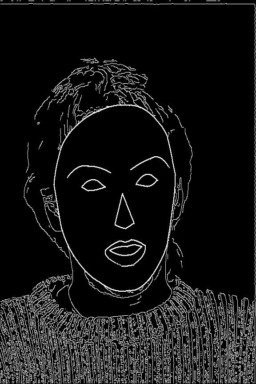

In [10]:
Image.fromarray((input_tensor[0,0,0]*255).cpu().detach().numpy().astype('uint8'), 'L')

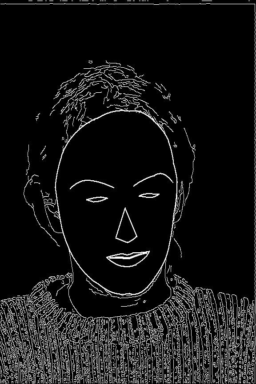

In [11]:
Image.fromarray((true_tensor[0,0,5]*255).cpu().detach().numpy().astype('uint8'), 'L')

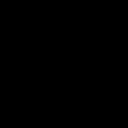

In [11]:
Image.fromarray((pred_tensor[0,0,2]*255).cpu().detach().numpy().astype('uint8'), 'L')

In [32]:
pred_tensor

tensor([[[[[-5.5757e-06, -7.1579e-06, -9.8266e-06,  ..., -6.5471e-06,
            -8.5114e-06, -4.9561e-06],
           [-1.1762e-05, -4.2717e-06, -1.8106e-05,  ..., -4.1266e-06,
            -1.6891e-05, -3.6552e-06],
           [-1.0076e-05, -1.0636e-05, -1.5776e-05,  ..., -1.0134e-05,
            -1.4417e-05, -6.7964e-06],
           ...,
           [-1.1241e-05, -4.4819e-06, -1.8789e-05,  ..., -3.6552e-06,
            -1.2943e-05, -3.7843e-06],
           [-1.0434e-05, -1.2457e-05, -1.7265e-05,  ..., -9.0997e-06,
            -1.2721e-05, -6.3183e-06],
           [-7.9910e-06, -4.0314e-06, -1.1992e-05,  ..., -3.3864e-06,
            -7.6571e-06, -3.7184e-06]],

          [[-6.6762e-06, -6.1828e-06, -1.2644e-05,  ..., -8.0231e-06,
            -1.4251e-05, -6.0869e-06],
           [-1.3766e-05, -3.0818e-06, -2.4805e-05,  ..., -3.6102e-06,
            -2.6193e-05, -3.6374e-06],
           [-1.3943e-05, -1.0283e-05, -2.3790e-05,  ..., -1.2296e-05,
            -2.6777e-05, -8.6844e-06],
 

In [13]:
torch.cat((condition_label.view(BatchSize, 1, 1, *ImgSize), train_img), dim=1).size()

torch.Size([4, 2, 1, 384, 256])